# Predicting the revoking of charity status

In [0]:
import sys
print (sys.version)

3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]


Analysis by Samantha Cassar

In [0]:
import numpy as np
from os import listdir
from os.path import isfile, join

import pandas as pd

import matplotlib.pyplot as plt

from datetime import date
from datetime import datetime

import warnings 
warnings.filterwarnings(action='ignore')

import seaborn as sns

# Data Overview & Import

A charity return with the CRA requires the completion of multiple forms. The main form is the [T3010 Registered Charity Information Return](https://www.canada.ca/content/dam/cra-arc/formspubs/pbg/t3010/t3010-fill-18e.pdf) form.

The data collected via this form is spread across several tables. The main financial data is captured in 2 tables (<b>Financial Section A_ B and C</b> and <b>Financial Section D & Schedule 6</b>), while each proceeding schedule has its own table:
<b>
- Schedule 1_ Foundations
- Schedule 2_ Activities Outside Canada
- Schedule 3_ Compensation
- Schedule 5_ Non-Cash gifts
- Schedule 7_ Description
- Schedule 7_ Political Activities - Outside Canada
- Schedule 7_ Political Activities - Resources
</b>

Finally, the text information capturing new and ongoing programs in this same form is captured in separate table <b>New and Ongoing Programs</b>.

Other tables:

- The <b>Gift</b> table characterizes money transfers to donation recipients and other organizations, captured in an additional form ([T1236 Qualified Donees Worksheet/Amounts provided to other organizations](https://www.canada.ca/content/dam/cra-arc/formspubs/pbg/t1236/t1236-fill-18e.pdf)).
- The <b>Ident</b> table looks to include profile data for each CRA account.
- The <b>Trustee</b> table includes data captured in a separate form, [T1235 Directors/Trustees and Like Officials](https://www.canada.ca/content/dam/cra-arc/formspubs/pbg/t1235/t1235-fill-18e.pdf).

Files with a hashtag in front of the name serve as lookup tables.

## REGISTERED

### Financial Section A_ B and C

Glancing at the csv files in Excel, here is what we know about these files:

<b> Financial Section A_B and C</b>

- Data reflects fiscal years that ended in 2018. These dates differ across entries.
- Each row represents a registered entity and each column represents a different part of the T3010 Registered Charity Information Return Form.
- Each row has a BN/Registration number, which links to the <b>Ident</b> table. (to confirm)
- Columns 1200-1220 look to refer to different areas of programming that the charity engages in (using codes from <b># Programs</b> lookup table), along with what proportion of their resources/efforts are allocated to this category. It is unclear where this data is captured, however, as these fields are not present in the form.
- Columns 1510-5830 appear to capture different fields within the form. Most are sparsely filled.

In [0]:
registered_path = r'E:\Data\Charity Tax Returns\2018 T3010 Data as of Jan 2020\Registered'
registered_files = [f for f in listdir(registered_path) if isfile(join(registered_path, f))]

registered_path = registered_path + '\\'

financial_df1 = pd.read_csv(registered_path + 'Financial Section A_ B and C.csv', encoding='latin-1', dtype=str)
financial_df2 = pd.read_csv(registered_path + 'Financial Section D & Schedule 6.csv', encoding='latin-1', dtype=str)
identities_df = pd.read_csv(registered_path + 'Ident.csv', encoding='latin-1', dtype=str)

#setting up lookup tables
category_table = pd.read_csv(registered_path + '# Category_Sub-Category.csv', encoding='latin-1', dtype=str)
designation_table = pd.read_csv(registered_path + '# Designation.csv', encoding='latin-1', dtype=str)
programs_table = pd.read_csv(registered_path + '# Programs.csv', encoding='latin-1', dtype=str)

category_table = category_table[['Category Code','Category English Desc', 'Sub-Category Code', 'Sub-Category English Desc']] \
                .rename(columns={'Category English Desc':'Category', 'Sub-Category English Desc':'Sub-Category'})
    
designation_table = designation_table[['Designation Code', 'Description_E']] \
                    .rename(columns={'Description_E':'Designation'})
    
programs_table = programs_table[['Line 1200, 1210, 1220', 'English Description']] \
                .rename(columns={'Line 1200, 1210, 1220':'Program Code', 'English Description':'Program'})

# REVOKED/ANNULLED

The tables in this second directory look to characterize which CRA charity accounts revoked or had their charity status annulled. A <b># Reason</b> lookup table provides different reason codes for doing so.

The <b>List of registered charities</b> table here looks identical with the <b>Ident</b> table in the Registered directory.

In [0]:
revoked_path = r'E:\Data\Charity Tax Returns\2018 T3010 Data as of Jan 2020\Revoked and Annulled'
revoked_files = [f for f in listdir(revoked_path) if isfile(join(revoked_path, f))]

revoked_path = revoked_path + '\\'
revoked_df = pd.read_csv(revoked_path + 'List of revoked & annulled charities.csv', encoding='latin-1', dtype=str)

reason_table = pd.read_csv(revoked_path + '# Reason.csv', encoding='latin-1', dtype=str)
reason_table = reason_table[['ReasonCode', 'DescriptionE']].rename(columns={'DescriptionE': 'Revoked Reason'})

revoked_df = pd.merge(revoked_df, reason_table, left_on='Reason code', right_on='ReasonCode', how='left')

revoked_df['Revoked Date'] = revoked_df['Effective date of status'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

#filtering for revoked charities whose status was revoked since 2018, the year for which we have charity data.
revoked_df = revoked_df[revoked_df['Revoked Date'] >= pd.Timestamp(2018,1,1)]
revoked_df = revoked_df[['BN/Registration number', 'Legal name', 'Revoked Date', 'Revoked Reason']]

# Data setup

Let's create a new dataset to characterize each charity, using the lookup tables to fill in coded information.

In [0]:
df = pd.merge(identities_df, financial_df1, left_on='BN/Registration Number', right_on='BN/Registration number', how='outer')
df = pd.merge(df, financial_df2, left_on='BN/Registration Number', right_on='BN/Registration number', how='outer')

df['Category code'] = df['Category code'].astype(int).astype(str)
df['Sub-category code'] = df['Sub-category code'].astype(int).astype(str)

df = pd.merge(df, category_table, how='left', left_on=['Category code', 'Sub-category code'], right_on=['Category Code', 'Sub-Category Code'])
df = pd.merge(df, designation_table, left_on='Designation code', right_on='Designation Code', how='left')

df = pd.merge(df, programs_table, left_on='1200 Program Area Code', right_on='Program Code', how='left').rename(columns={'Program':'1200 Program Area'})
df = pd.merge(df, programs_table, left_on='1210 Program Area Code', right_on='Program Code', how='left').rename(columns={'Program':'1210 Program Area'})
df = pd.merge(df, programs_table, left_on='1220 Program Area Code', right_on='Program Code', how='left').rename(columns={'Program':'1220 Program Area'})

df = pd.merge(df, revoked_df, how='left', left_on='BN/Registration Number', right_on='BN/Registration number')

## Missing data

In [0]:
#checking for missing revoked data
filed_charities = len(df['BN/Registration Number'])
revoked_charities = len(revoked_df['BN/Registration number'])
missing_revoked_charities = len(set(revoked_df['BN/Registration number']) - set(df['BN/Registration Number']))
filed_revoked_charities = len(set(revoked_df['BN/Registration number']) & set(df['BN/Registration Number']))

print("There are {} charities with 2018 information filed, {} revoked charities, and {} charities who have revoked their status since 2018 but are missing 2018 information on file. \n \nThis means we only have information for {} revoked charities, or {}% of total revoked charities.".format(filed_charities, revoked_charities, missing_revoked_charities, filed_revoked_charities, round(filed_revoked_charities / revoked_charities * 100)))

There are 84548 charities with 2018 information filed, 4373 revoked charities, and 2916 charities who have revoked their status since 2018 but are missing 2018 information on file. 
 
This means we only have information for 1457 revoked charities, or 33% of total revoked charities.


# Data cleaning

In [0]:
#remove duplicate columns
df = df[df.columns.drop(list(df.filter(regex='_y')))]
df.columns = df.columns.str.rstrip('_x')

#keep only first row if charity appears more than once
df.drop_duplicates(subset='BN/Registration Number', keep = 'first', inplace = True)

#create status flag
df['Status'] = np.nan
df.loc[df['Revoked Reason'].isnull(), 'Status'] = 'Registered'
df.loc[df['Status'] != 'Registered', 'Status'] = 'Revoked'

#Bring in data dictionary with data types to assign each column
data_dic = pd.read_csv(r'E:\Data\Charity Tax Returns\2018 T3010 Data as of Jan 2020\data_dictionary.csv')

#make list of columns that need to be float type
float_list = list(data_dic.loc[data_dic['data_type']=='float','column_name'])

#make list of columns that need to be bool type
bool_list = list(data_dic.loc[data_dic['data_type']=='bool','column_name'])

#change columns in float list to float
df[float_list] = df[float_list].apply(lambda x: x.str.replace(',', '')) #remove leading $ character
df[float_list] = df[float_list].apply(lambda x: x.str.replace('$', '')) #remove commas from numbers
df[float_list] = df[float_list].apply(pd.to_numeric)

#change columns in bool list to bool
df[bool_list] = df[bool_list].apply(lambda x : np.where(x == 'Y', '1', np.where(x == 'N', '0', np.nan)))

#filtering for charities only (75% of total rows)
df = df[df['Designation']=='Charitable Organization']

#removing columns with more than 50% of data missing, keeping 'Revoked Date'
columns = np.append(df.columns[df.isnull().mean() <= 0.5], ['Revoked Date', 'Revoked Reason'])
df = df[columns]

#putting registration date into datetime format
df['Registration date'] = df['Registration date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

#Montreal appears as both MONTREAL and MONTRÉAL - let's fix this
df.loc[df['City']=='MONTRÉAL', 'City'] = 'MONTREAL'

## Class distribution

What is the revoked/registered split?

In [0]:
df2 = df.reset_index().groupby('Status').size().to_frame('count')
df2['percentage'] = round(df2['count'] / len(df), 3)
print (df2)

            count  percentage
Status                       
Registered  72252       0.983
Revoked      1239       0.017


<b>Less than 2% of 73.5K charities who filed information with CRA in 2018 fiscal year had their charity status revoked between 2018-2020.</b>

## Plotting

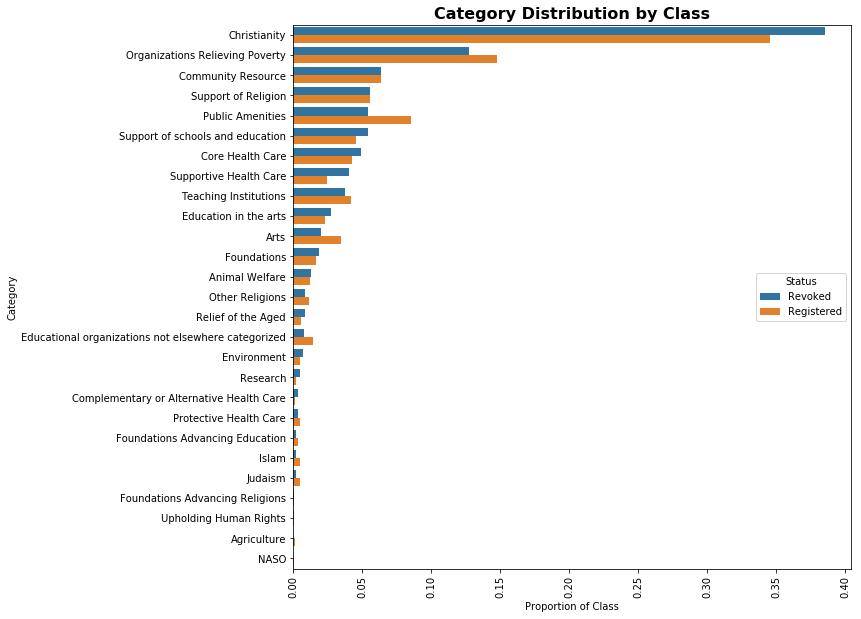

In [0]:
plt.figure(figsize=[10,10])
cat_df = df.groupby(['Status','Category'])['BN/Registration Number'].agg(['count'])
cat_df['category_perc'] = cat_df['count'] / (cat_df.groupby(level=0)['count'].transform('sum'))
cat_df = cat_df['category_perc'].reset_index().sort_values(['Status', 'category_perc'], ascending=False)

sns.barplot(x='category_perc', y='Category', hue='Status', data=cat_df)
plt.xticks(rotation=90)
plt.ylabel('Category')
plt.xlabel('Proportion of Class')
plt.title('Category Distribution by Class', fontsize = 16, fontweight='bold')
plt.show();

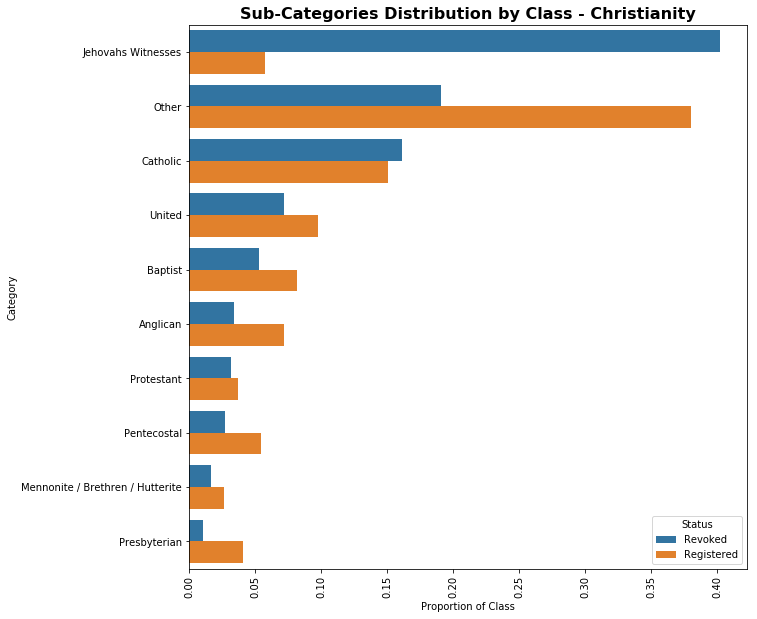

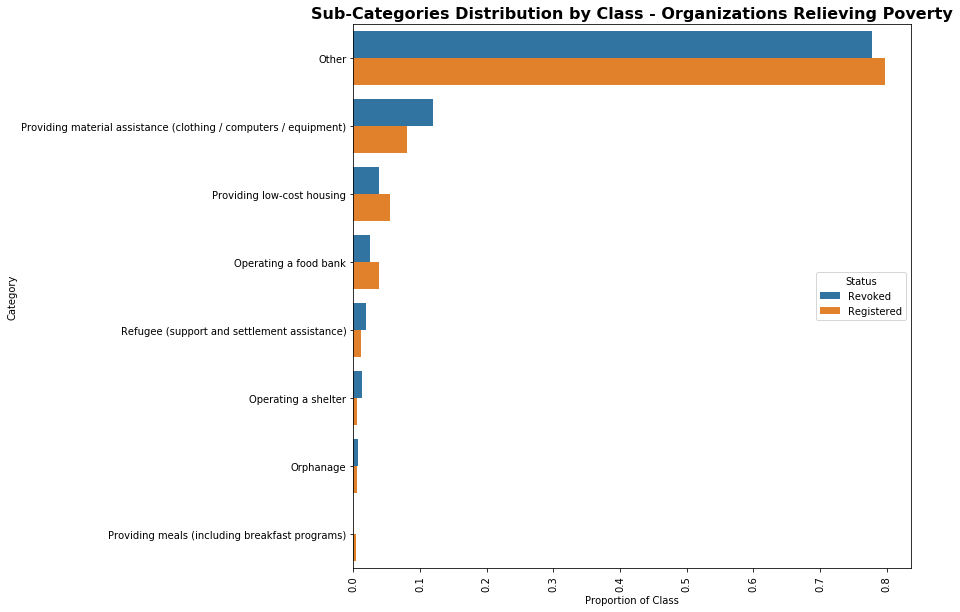

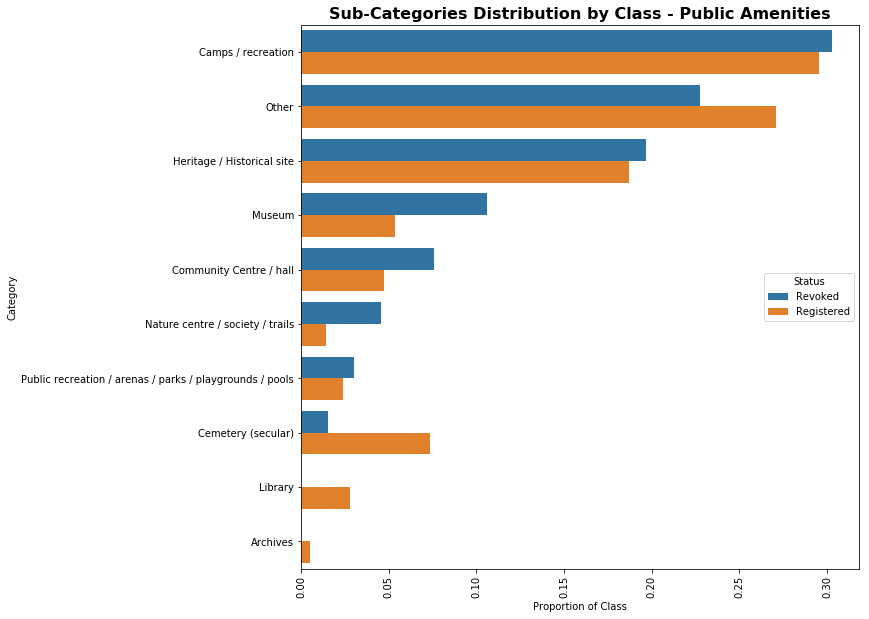

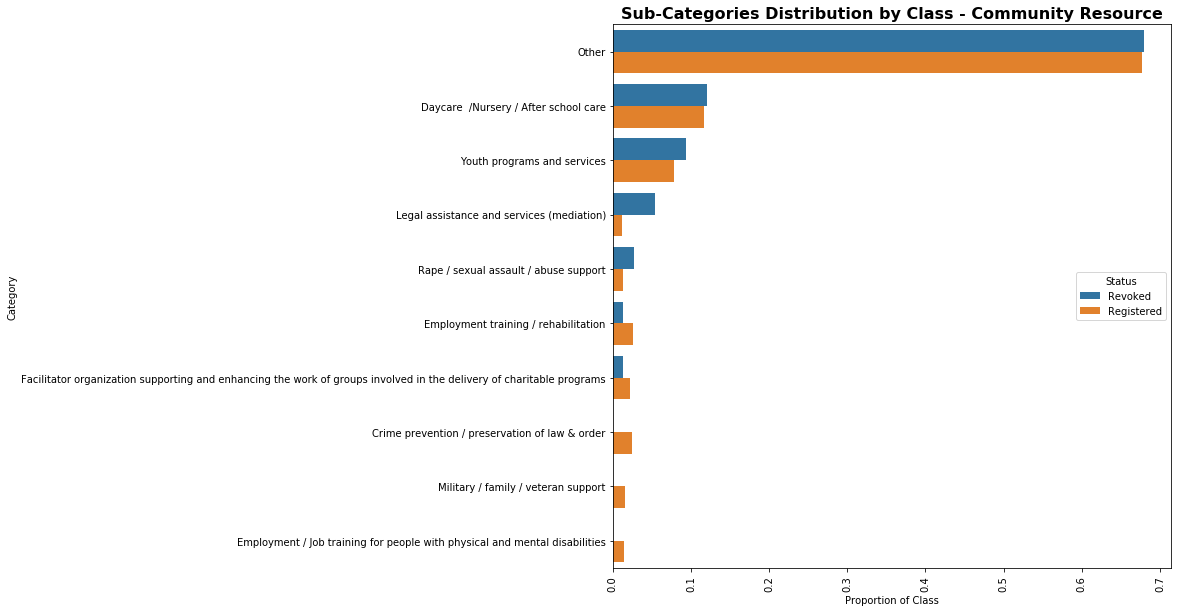

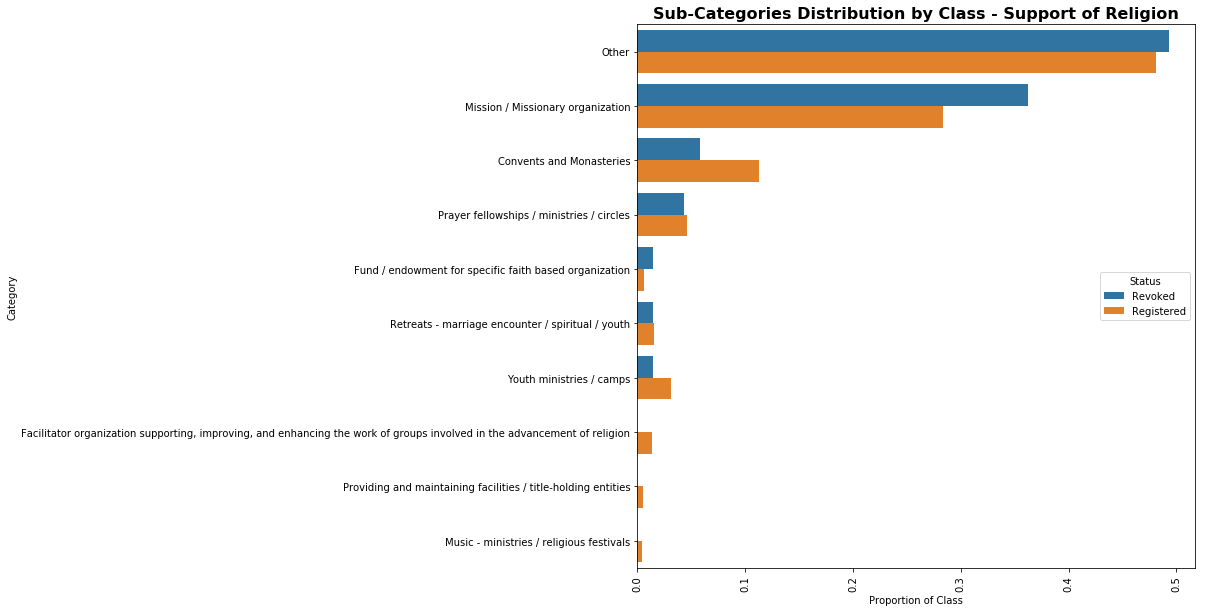

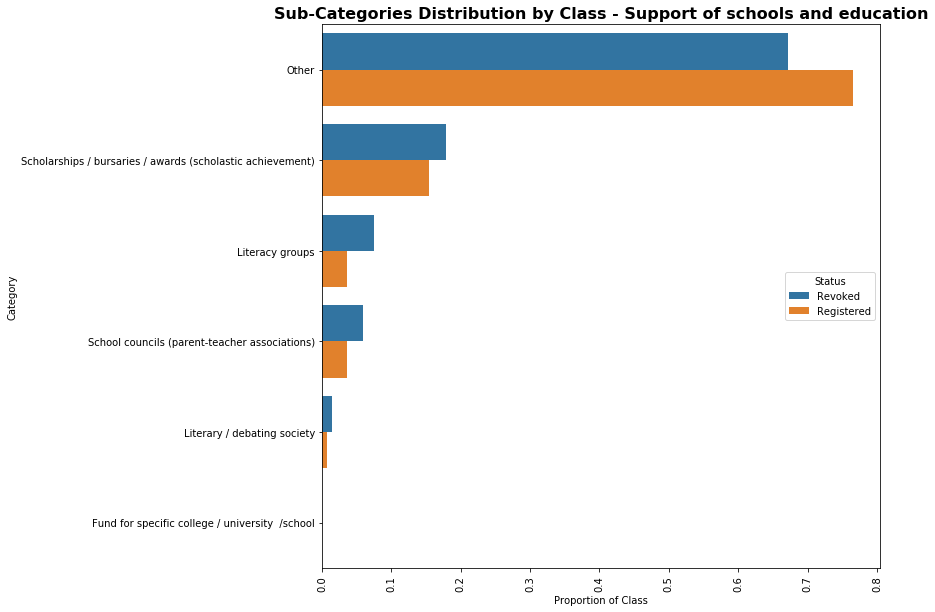

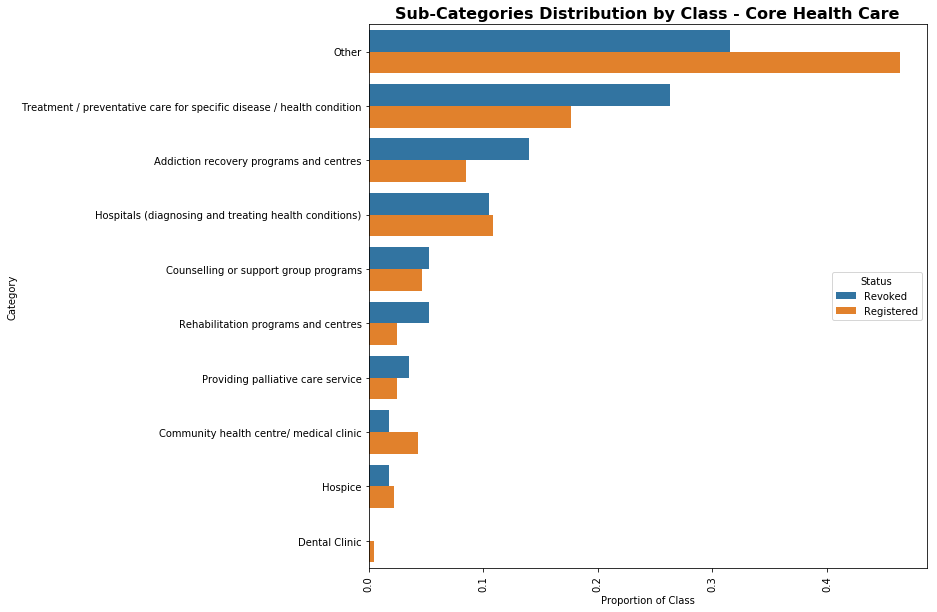

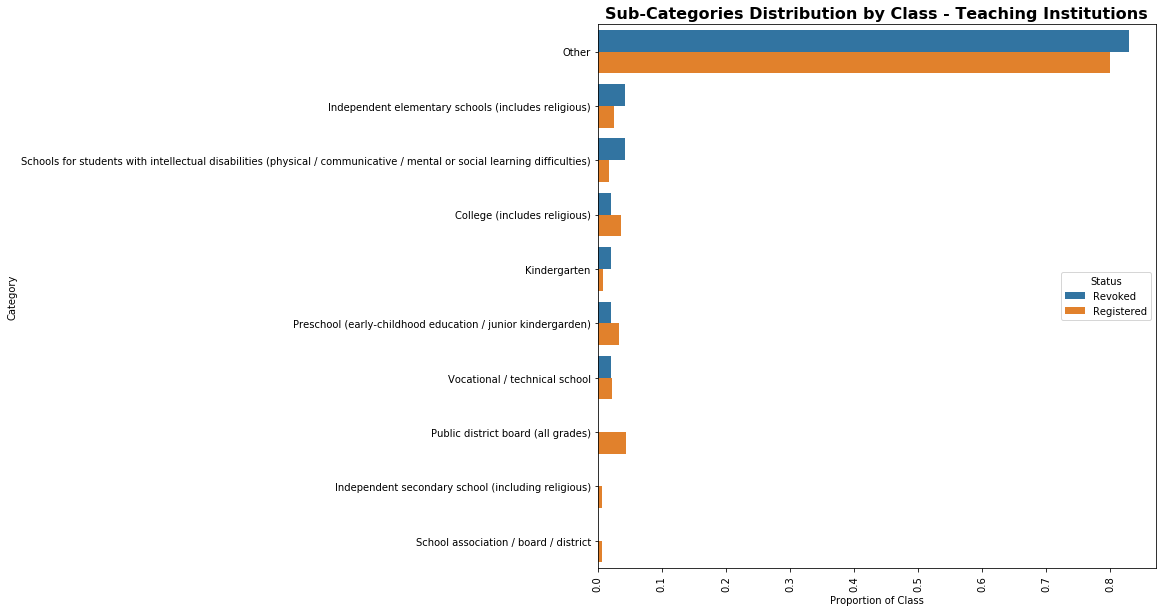

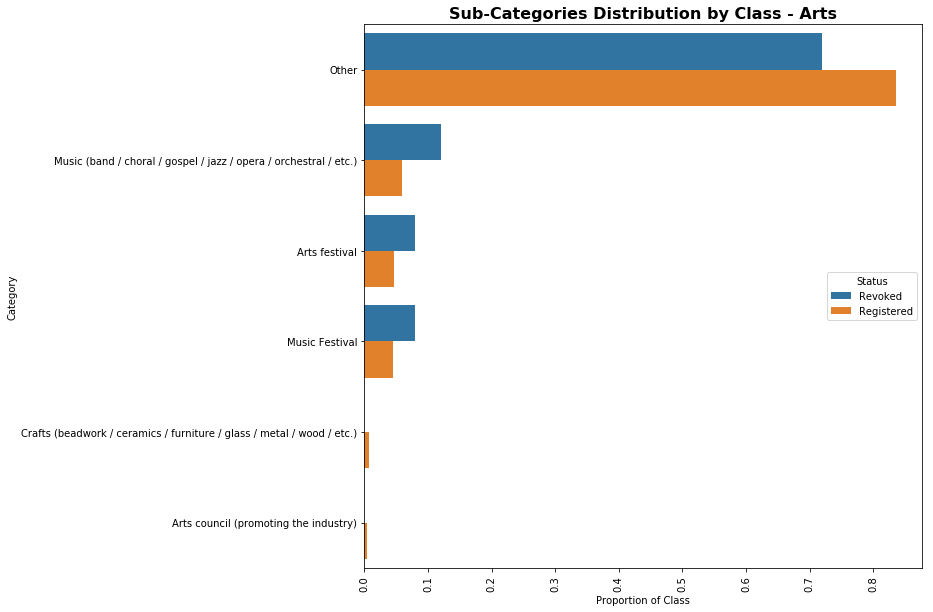

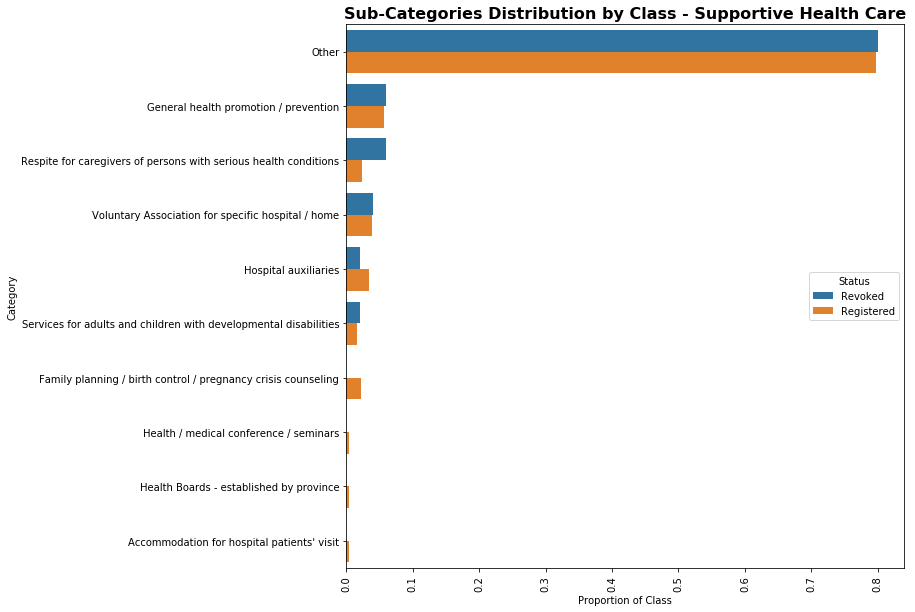

In [0]:
top_categories = df['Category'].value_counts(dropna=False)[:10].index.tolist()

for category in top_categories:
    cat_df = df.loc[df['Category']==category, :] #filter for category data
    top_subcategories = cat_df['Sub-Category'].value_counts(dropna=False)[:10].index.tolist()
    cat_df = cat_df.loc[cat_df['Sub-Category'].isin(top_subcategories), :]
    
    plt.figure(figsize=[10,10])
    cat_df = cat_df.groupby(['Status','Sub-Category'])['BN/Registration Number'].agg(['count'])
    cat_df['subcategory_perc'] = cat_df['count'] / (cat_df.groupby(level=0)['count'].transform('sum'))
    cat_df = cat_df['subcategory_perc'].reset_index().sort_values(['Status', 'subcategory_perc'], ascending=False)

    sns.barplot(x='subcategory_perc', y='Sub-Category', hue='Status', data=cat_df)
    plt.xticks(rotation=90)
    plt.ylabel('Category')
    plt.xlabel('Proportion of Class')
    plt.title('Sub-Categories Distribution by Class - {}'.format(category), fontsize = 16, fontweight='bold')
    plt.show();

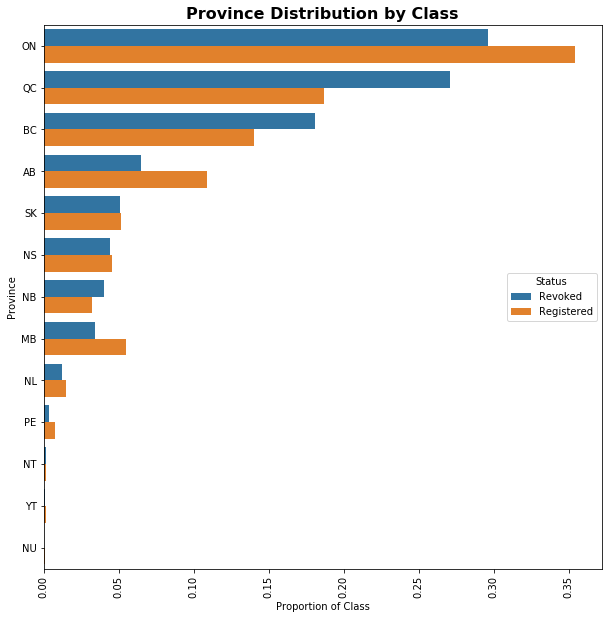

In [0]:
plt.figure(figsize=[10,10])
canada_provinces = ['ON', 'QC', 'BC', 'AB', 'SK', 'NS', 'NB', 'MB', 'NL', 'PE', 'NT', 'YT', 'NU']

#filter for Canada provinced
cat_df = df.loc[df['Province'].isin(canada_provinces), :]

cat_df = cat_df.groupby(['Status','Province'])['BN/Registration Number'].agg(['count'])
cat_df['category_perc'] = cat_df['count'] / (cat_df.groupby(level=0)['count'].transform('sum'))
cat_df = cat_df['category_perc'].reset_index().sort_values(['Status', 'category_perc'], ascending=False)

sns.barplot(x='category_perc', y='Province', hue='Status', data=cat_df)
plt.xticks(rotation=90)
plt.ylabel('Province')
plt.xlabel('Proportion of Class')
plt.title('Province Distribution by Class', fontsize = 16, fontweight='bold')
plt.show();

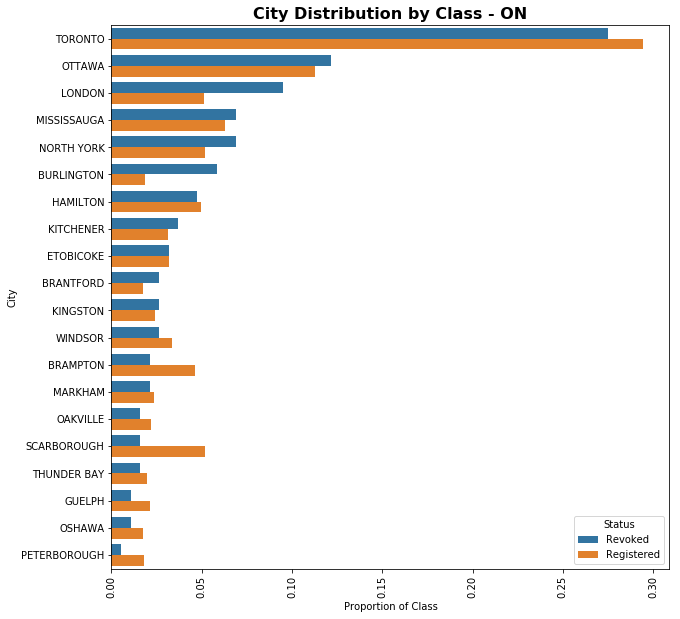

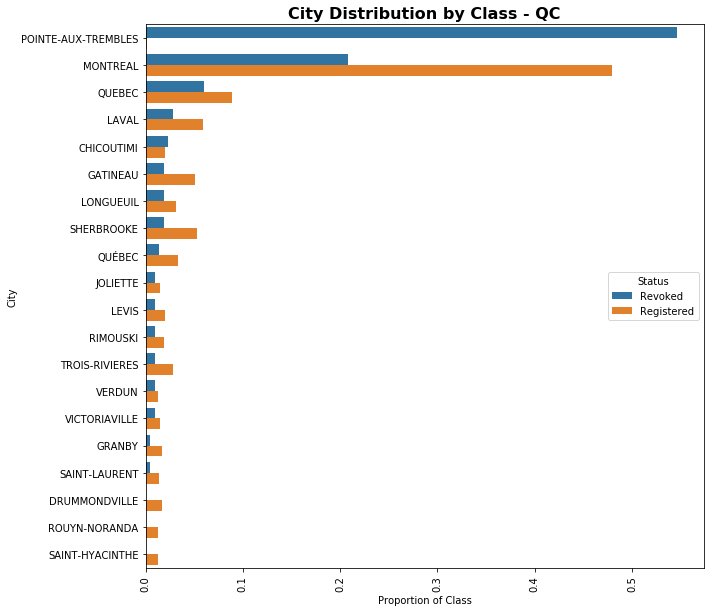

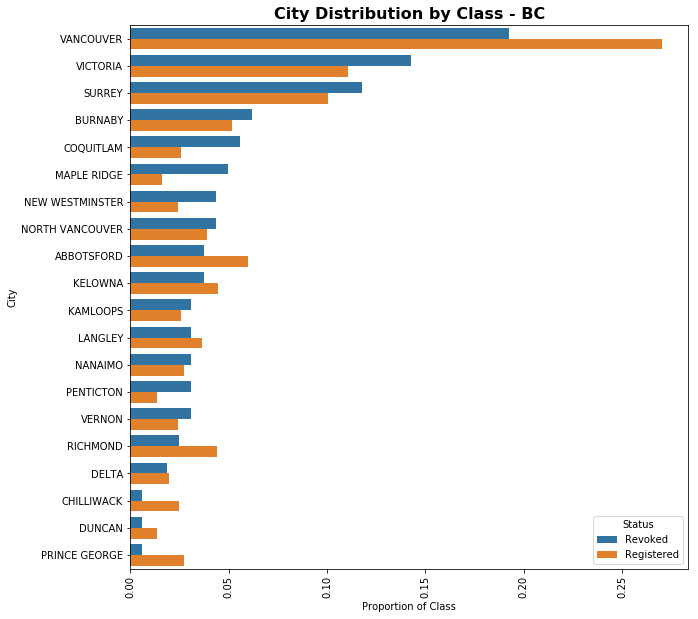

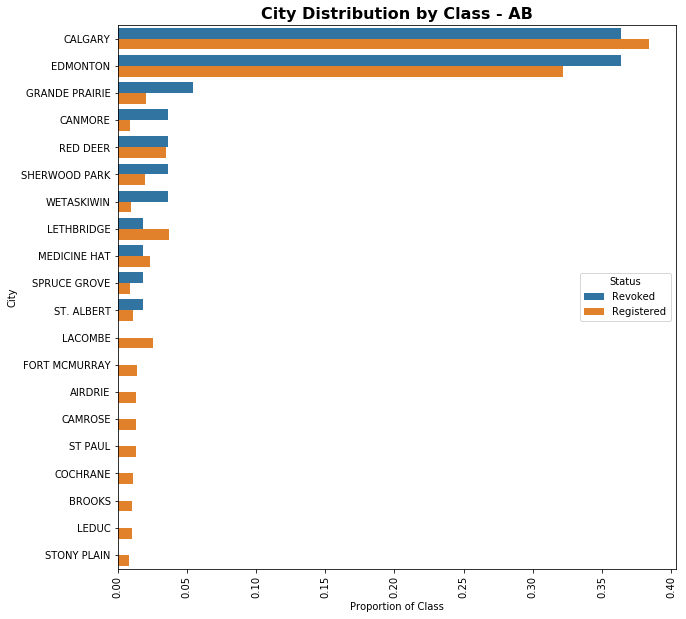

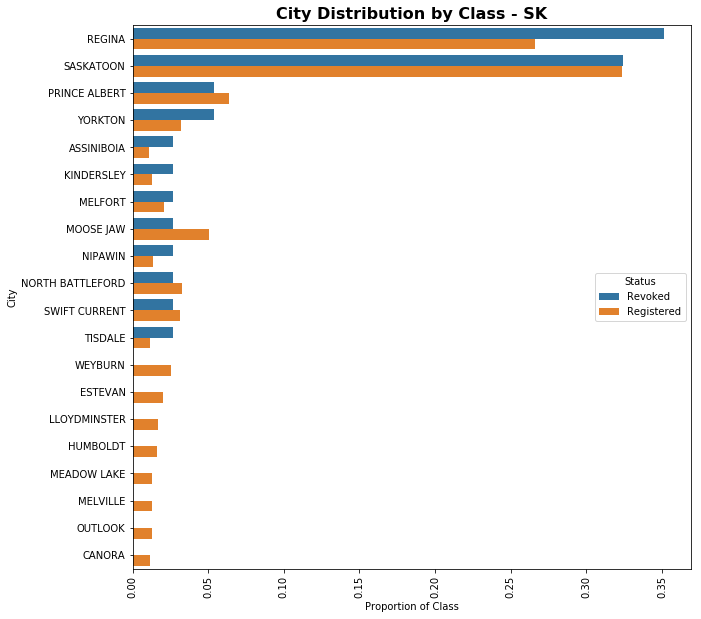

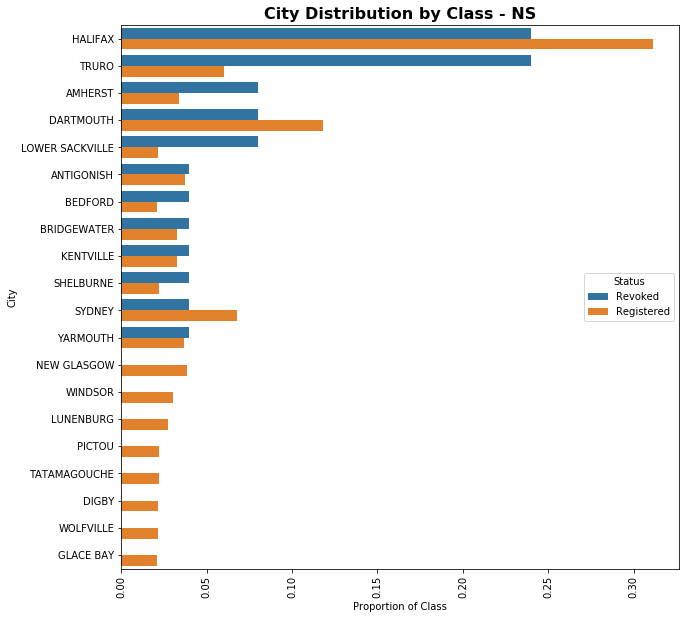

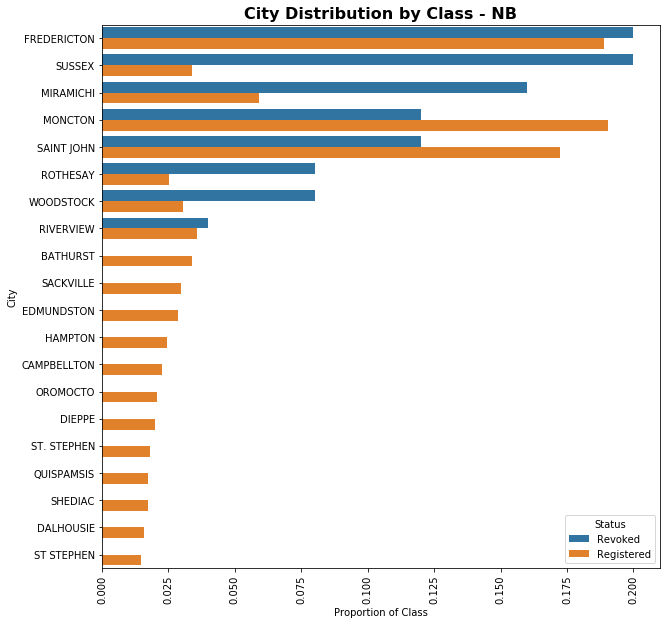

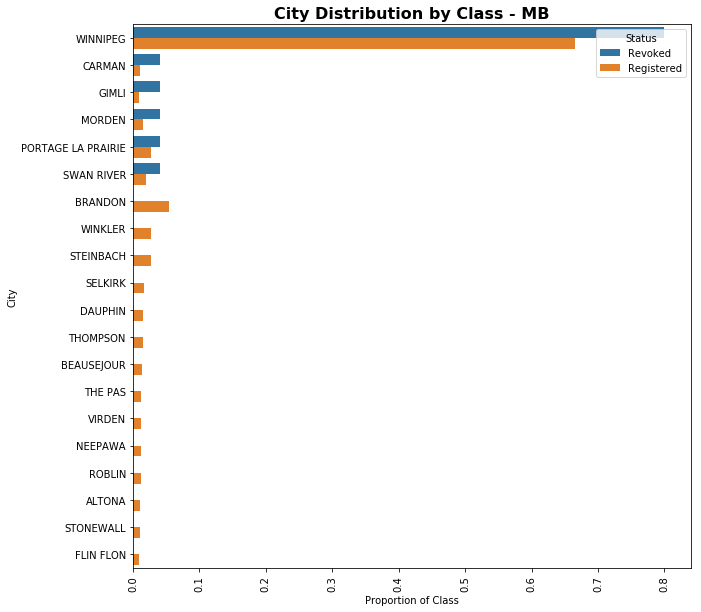

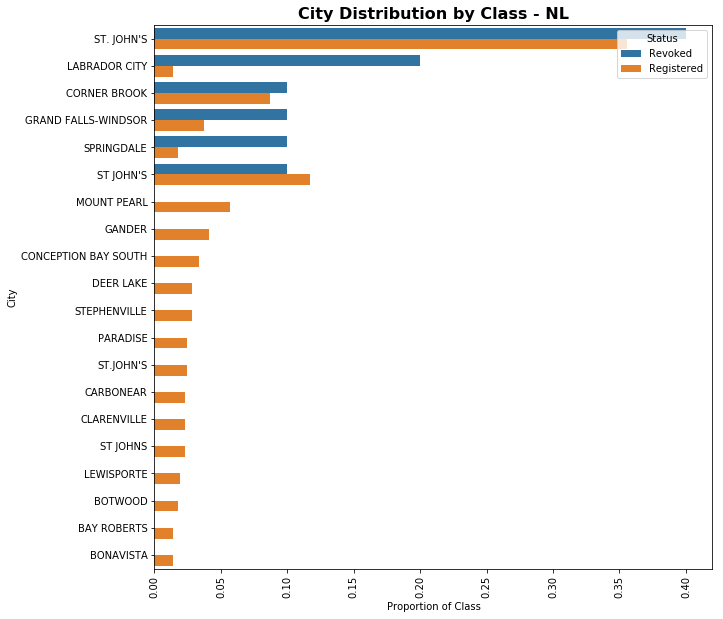

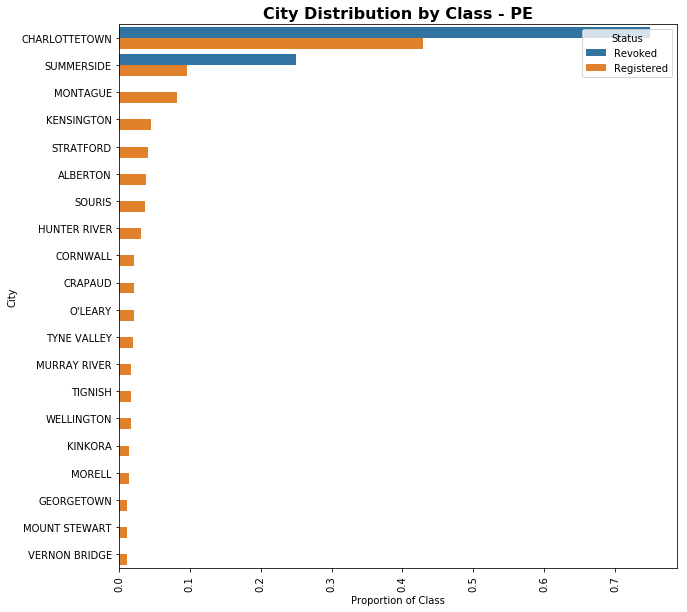

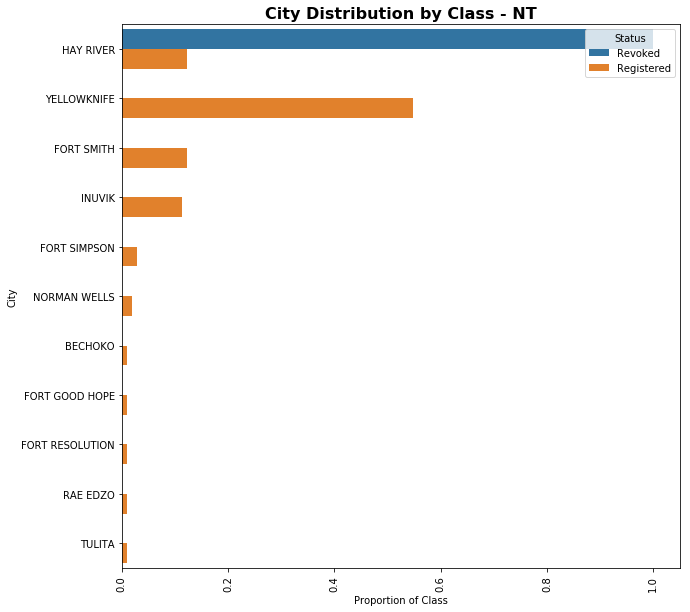

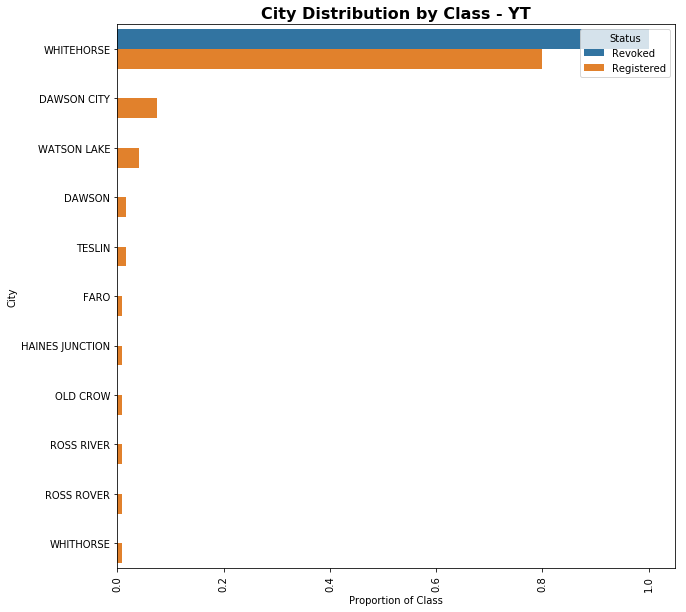

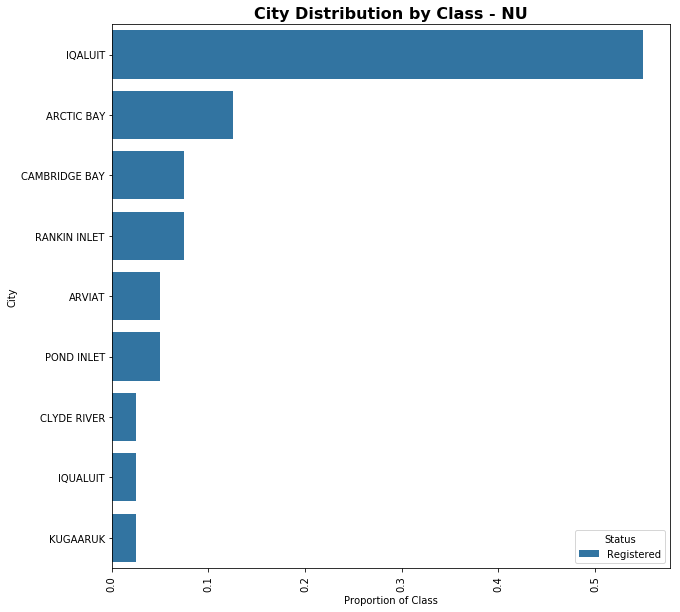

In [0]:
for province in canada_provinces:
    cat_df = df.loc[df['Province'] == province, :] #filter for province data
    top_cities = cat_df['City'].value_counts(dropna=False)[:20].index.tolist()
    cat_df = cat_df.loc[cat_df['City'].isin(top_cities), :]
    
    plt.figure(figsize=[10,10])
    cat_df = cat_df.groupby(['Status','City'])['BN/Registration Number'].agg(['count'])
    cat_df['subcategory_perc'] = cat_df['count'] / (cat_df.groupby(level=0)['count'].transform('sum'))
    cat_df = cat_df['subcategory_perc'].reset_index().sort_values(['Status', 'subcategory_perc'], ascending=False)

    sns.barplot(x='subcategory_perc', y='City', hue='Status', data=cat_df)
    plt.xticks(rotation=90)
    plt.ylabel('City')
    plt.xlabel('Proportion of Class')
    plt.title('City Distribution by Class - {}'.format(province), fontsize = 16, fontweight='bold')
    plt.show();

#### Program Areas

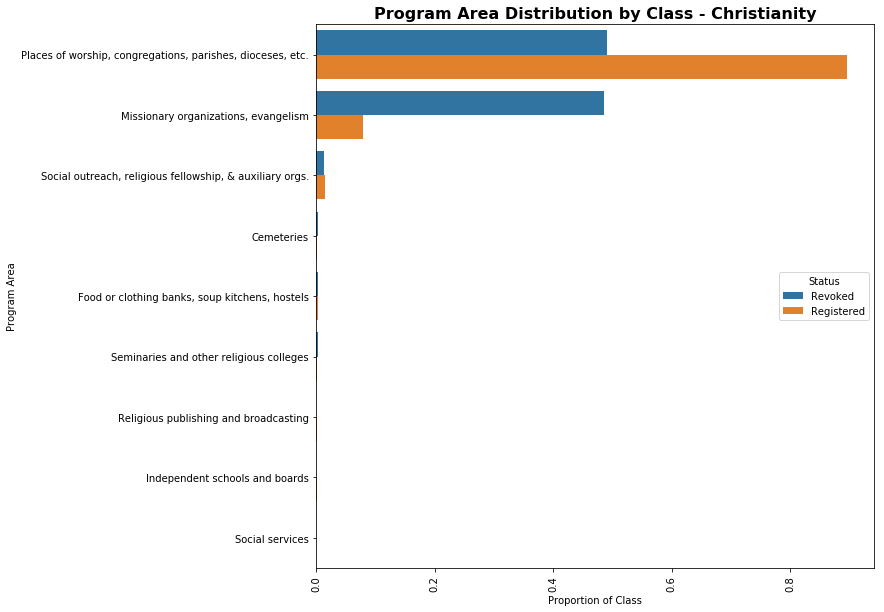

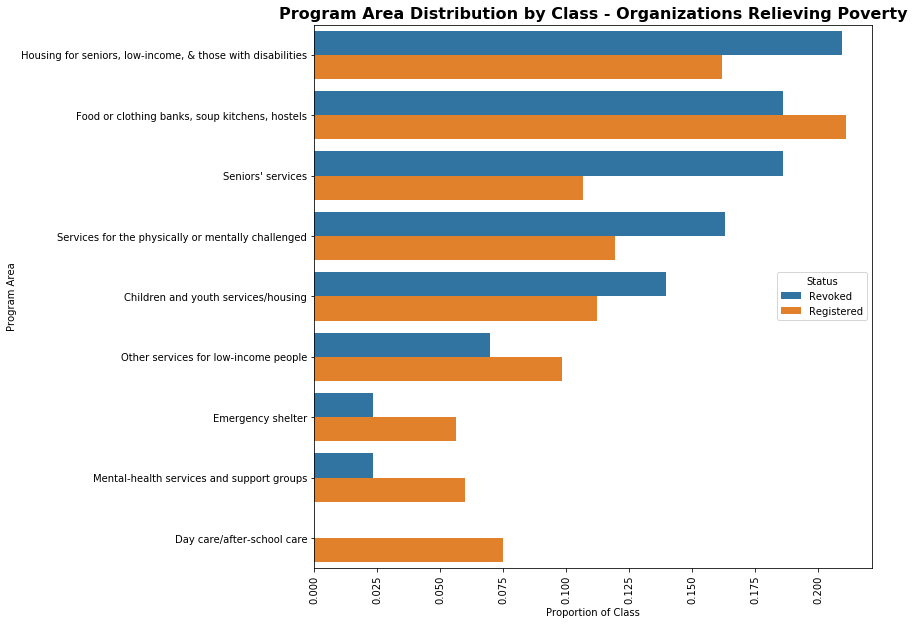

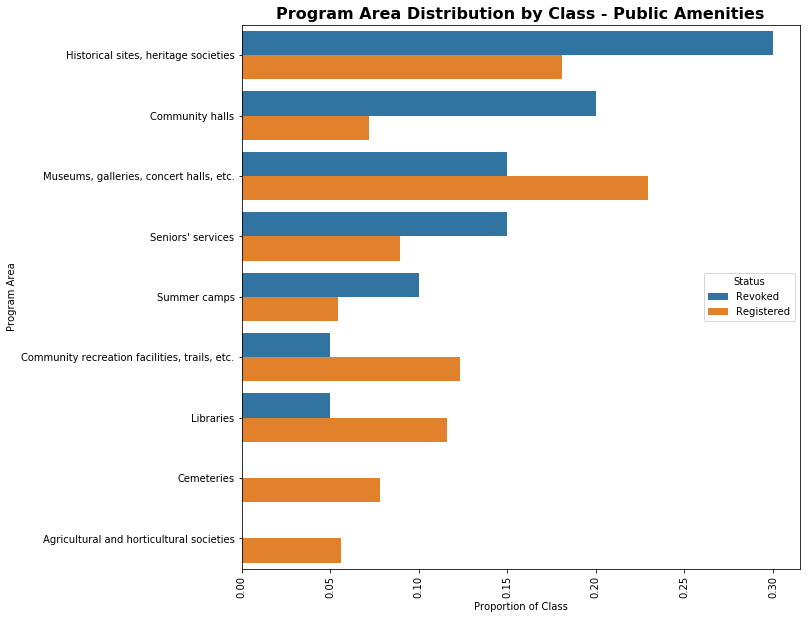

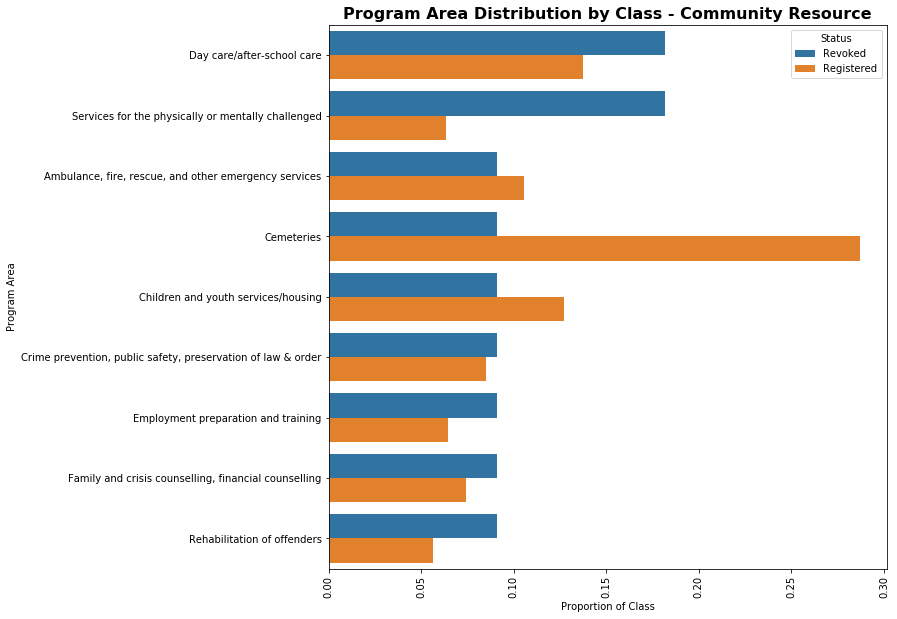

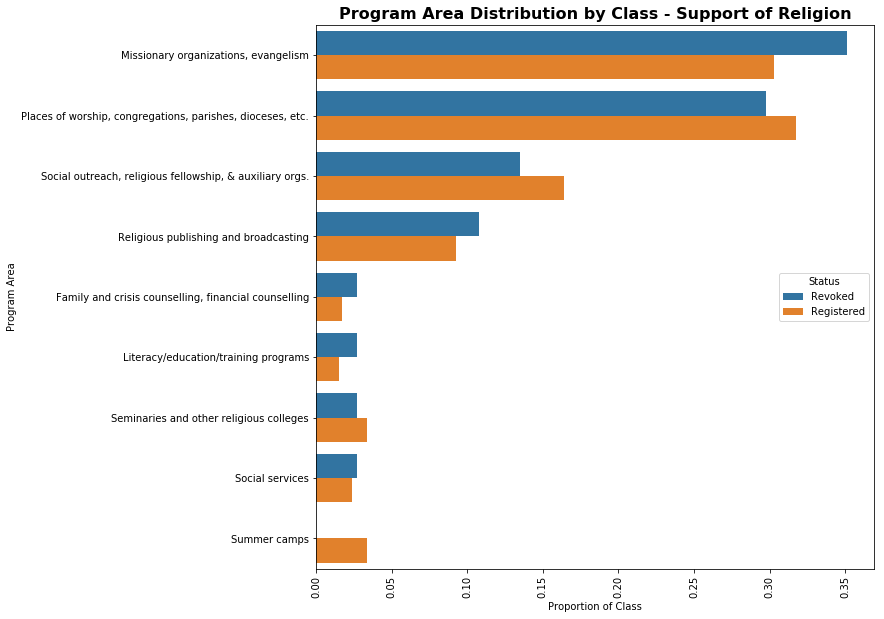

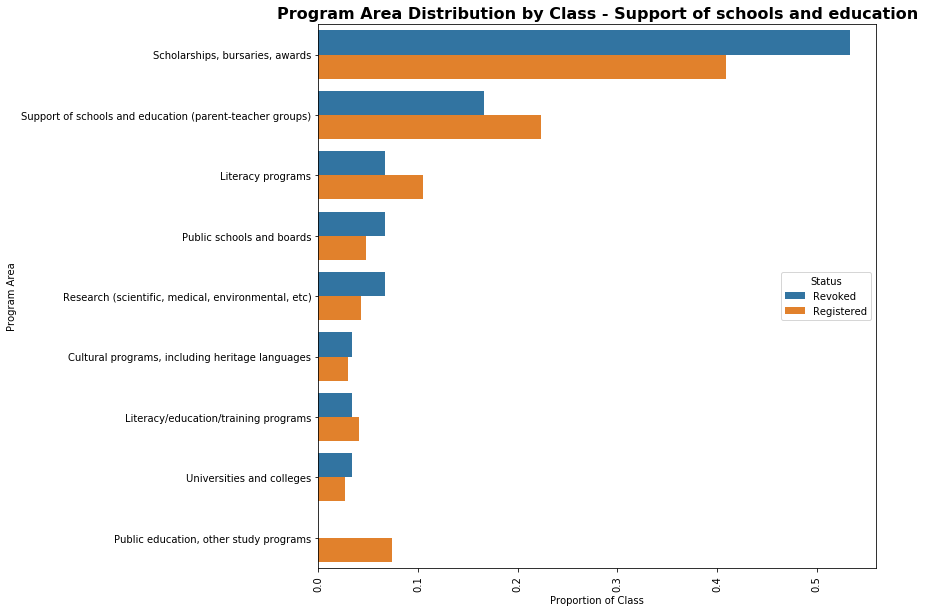

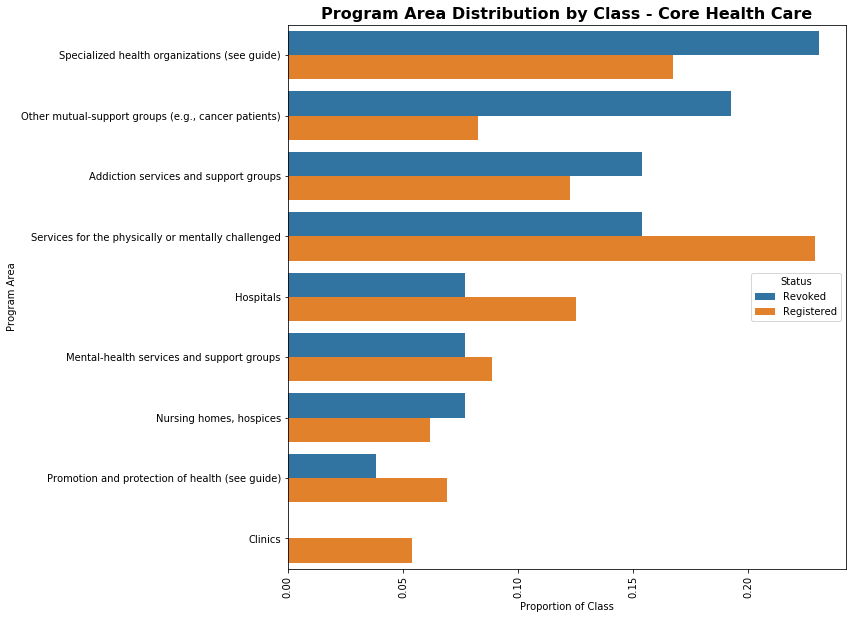

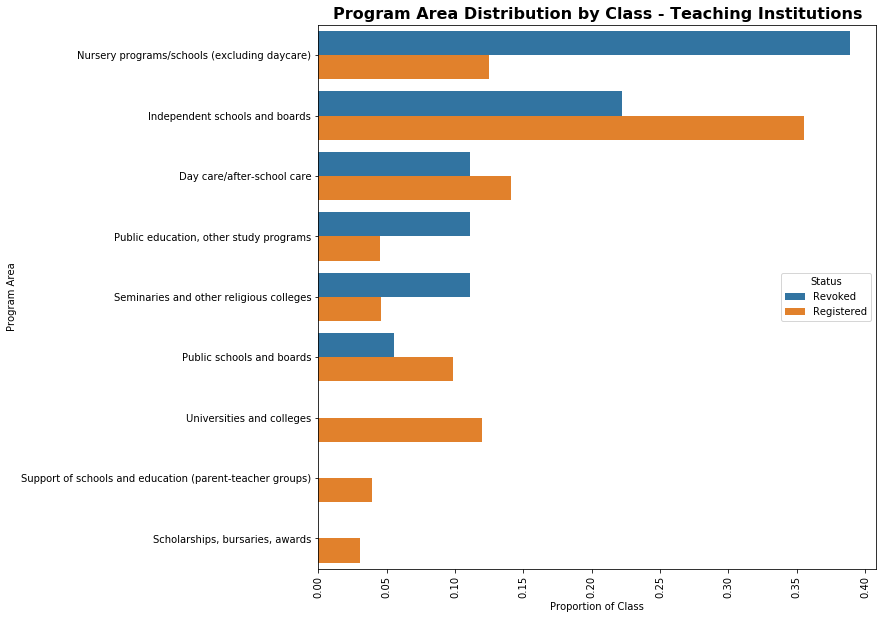

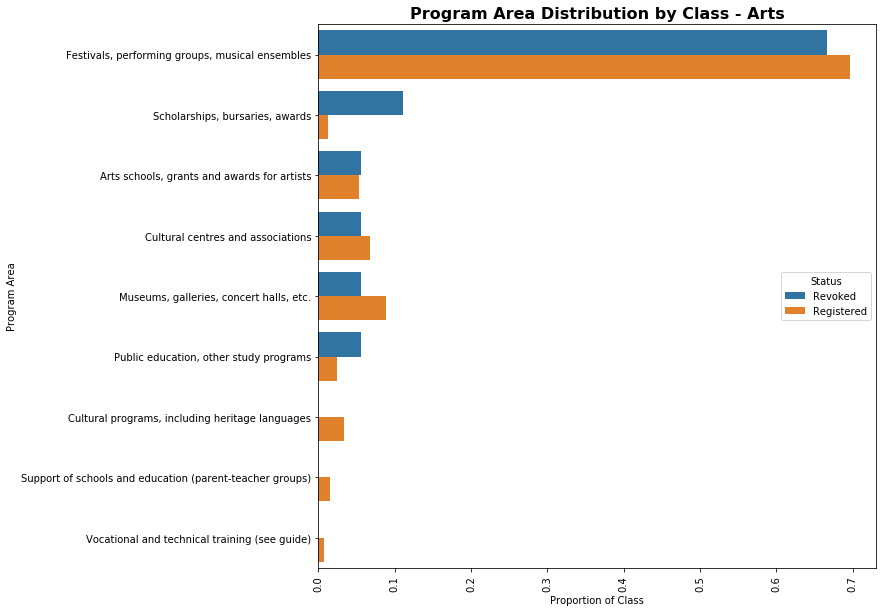

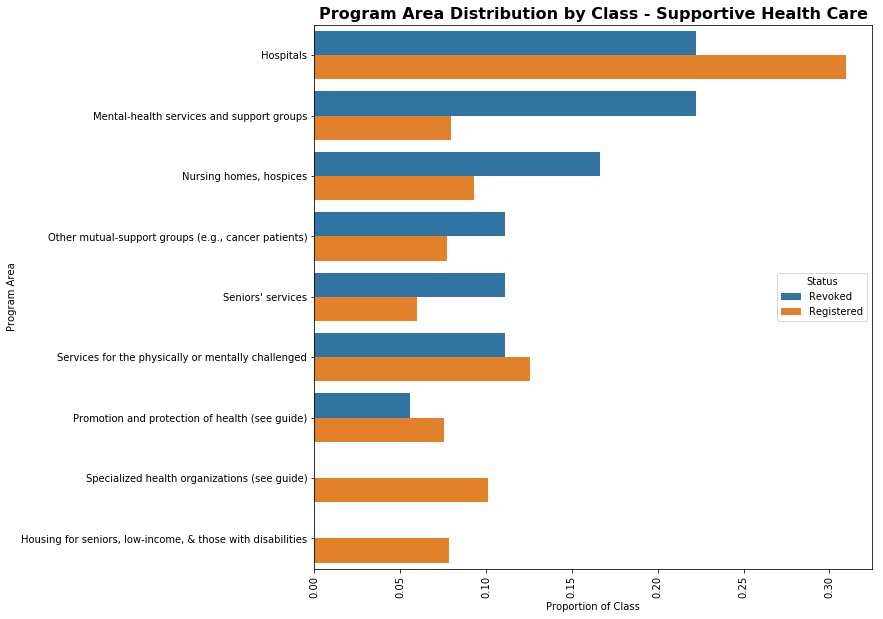

In [0]:
top_categories = df['Category'].value_counts(dropna=False)[:10].index.tolist()

for category in top_categories:
    cat_df = df.loc[df['Category']==category, :] #filter for category data
    cat_df = cat_df[df['1200 Program Area']!='(Free-form text)'] #removing free-form text responses for easy comparison
    top_program_areas = cat_df['1200 Program Area'].value_counts(dropna=False)[:10].index.tolist()
    cat_df = cat_df.loc[cat_df['1200 Program Area'].isin(top_program_areas), :]
    
    plt.figure(figsize=[10,10])
    cat_df = cat_df.groupby(['Status','1200 Program Area'])['BN/Registration Number'].agg(['count'])
    cat_df['subcategory_perc'] = cat_df['count'] / (cat_df.groupby(level=0)['count'].transform('sum'))
    cat_df = cat_df['subcategory_perc'].reset_index().sort_values(['Status', 'subcategory_perc'], ascending=False)

    sns.barplot(x='subcategory_perc', y='1200 Program Area', hue='Status', data=cat_df)
    plt.xticks(rotation=90)
    plt.ylabel('Program Area')
    plt.xlabel('Proportion of Class')
    plt.title('Program Area Distribution by Class - {}'.format(category), fontsize = 16, fontweight='bold')
    plt.show();

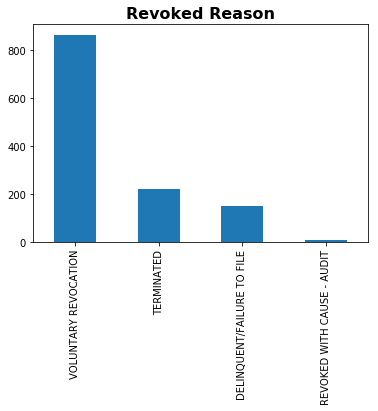

In [0]:
df.loc[df['Revoked Reason'].notnull(), 'Revoked Reason'].value_counts(dropna=False).plot(kind='bar')
plt.title('Revoked Reason', fontsize = 16, fontweight='bold')
plt.show()

## Financial Info

Total assets (4200), Total liabilities (4350)

Total revenue (4700), Total expenditures (5100)

Total accumulated (5500) / Total disbursed (5510)

Total expenditures by type (4950, 5000, 5010, 5020, 5030, 5040, 5050, 5100)

Total revenue by type (4510, 4530, 4540, 4550, 4560, 4570, 4571, 4575, 4580, 4590, 4600, 4610, 4620, 4630, 4640, 4650)

In [0]:
def removeOutliers(data, thresholdStd = 3):
    """
    This method returns all value indices which are farther away
    than thresholdStd standard deviationa
    """
    not_outliers = []
    mean = np.mean(data)
    std = np.std(data)
    if std == 0:
        return data
    
    for i, y in enumerate(data):
        z_score = (y - mean) / std
        if np.abs(z_score) <= thresholdStd:
            not_outliers.append(i)
    return not_outliers

In [0]:
df['all'] = ''

for col in df.select_dtypes(include='number').columns:
    title = data_dic.loc[data_dic['column_name']==col, 'description'].values[0]
    
    #remove outliers beyond 3 std devs
    not_outliers = removeOutliers(df[col])
    
    ax = sns.violinplot(x='all',y=col, hue='Status', data=df.iloc[not_outliers,:], split=True)
    ax.set_xlabel('')
    ax.set_ylabel(col.replace("_", " "))
    ax.set_title(col + ': ' + title, size=15)
    plt.show()

Q: Why do some columns show negative values? Is this a data entry error?

See columns:

- 4100
- 4530
- 4650
- 4820

In [0]:
'''
#bivariate plotting

#regression between two variables
sns.set(font='DejaVu Sans')
sns.jointplot([x col], [y col], df, kind='reg').fig.suptitle('y col Regression', y=1.01)

sns.lmplot([x col], [y col], df, col='Status').fig.suptitle('y col Regression - categorized by Status', y=1.05)
'''

## Dealing with Class Imbalance

For every charity that had its status revoked since 2018, there were approx. 57 charities that retained their status (1:57 ratio), representing a slight-to-moderate imbalance between classes. While the data appears to be biased in favour of charities that retained their status, this may not necessarily be a problem if this data represents what happens in reality.

Addressing the following questions can help us better understand if this class imbalance is at all problemmatic.
- <b>The most recent revocation date is Jan 22, 2020. On what date was this data shared by the government? Could an updated table of revoked charities be requested to ensure we're working with all revoked labels possible?</b> (Otherwise, potential mis-labeling of registered charities)
- <b>How do charities have their status revoked? Is this dataset complete or could some entries be missing due to under-reporting?</b> (Potentially causing mis-labeling of registered charities)
- <b>Do charities have to file their info each year?  Could charities forget to do so without any repercussions?</b> (Potentially causing an undersampling of both registered charities)
- <b>Could charities that planned on withdrawing their charity status in 2018 be discouraged from filing charity information in the same year?</b> (Potentially causing an undersampling of revoked charities)

And one more question that can be answered with existing data:
- <b>Is there any 2018 filing information missing for charities that were revoked 2018-2020?</b> (Potentially causing undersampling of revoked charities)

For now, let's assume that the data is representative and that in reality, less than 2 of 100 registered charities will have their status revoked in the next 2 years. This means we're good to go with using it for modelling purposes.

We can always come back to these considerations later.

## Choosing our metrics

[Towards Data Science](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28) provides a great visual of the confusion matrix and corresponding metrics generating using produced values. 

Below, we refer to <b>class 1</b> as <b>registered</b> and <b>class 2</b> as <b>revoked</b> charity status.
<img src='https://miro.medium.com/max/1400/1*Yslau43QN1pEU4jkGiq-pw.png', width='60%'>

Let's now determine what each box represents here and what we want to happen to it.

Maximize Orange <br />
True positive for "registered" class. Accurately predicting registered charities is always good.

Minimize Green <br />
False positive for "revoked" class. A charity that was predicted to "churn" (have their charity status revoked) erroneously could have consequences. Unnecessary resources could be spent to target that charity to either help them retain their status, or undue stress could result if they are notified of the risk when there really is no real risk.

Minimize Yellow <br />
False positive for "registered" class. One could argue that there could be greater consequences if a charity were to have their status revoked without the predicting of such. This could create a sense of false security, and have repercussions on the charity's decision-making, and in turn, charity status.

Maximize Blue <br />
True positive for "revoked" class. Accurately predicting revoked charities is what we ultimately want to do the most.

## Modelling

# Further reading

## Imbalanced datasets

[Handling imbalanced datasets in machine learning (Towards Data Science)](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28)

## Linear SVC

[scitkit-learn user guide](https://scikit-learn.org/stable/modules/svm.html#svm-classification)

[sklearn.svm.LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

## KNeighbours Classifier

[scikit-learn user guide](https://scikit-learn.org/stable/modules/neighbors.html#classification)

[sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)